In [1]:
import numpy as np
import librosa
import librosa.display
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
HOP_LENGTH = 512
N_FFT = 1024
COARSE_WIDTH = 20
REFINE_WIDTH = 30
TRIALS = 9
TEMPO_BOUNDS = (0.8, 1.2)

In [3]:
def log_mel(user_mp3, sample_rate=22050, n_mels=128, n_fft=N_FFT, hop_length=HOP_LENGTH, fmin=27.5, fmax=8000):
    # Load audio file
    y, sr = librosa.load(user_mp3, sr=sample_rate, mono=True)

    y_trimmed = librosa.effects.trim(y, top_db=30)[0]  # Trim silence from the beginning and end
    
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax)
    
    # Apply Gaussian filter
    mel_spectrogram = gaussian_filter(mel_spectrogram, sigma=(0.8,0.3))

    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return log_mel_spectrogram

In [5]:
def normalize_spectogram(spectogram):
    mu = spectogram.mean(axis=1, keepdims=True)
    sigma = spectogram.std(axis=1, keepdims=True)
    return (spectogram - mu) / sigma


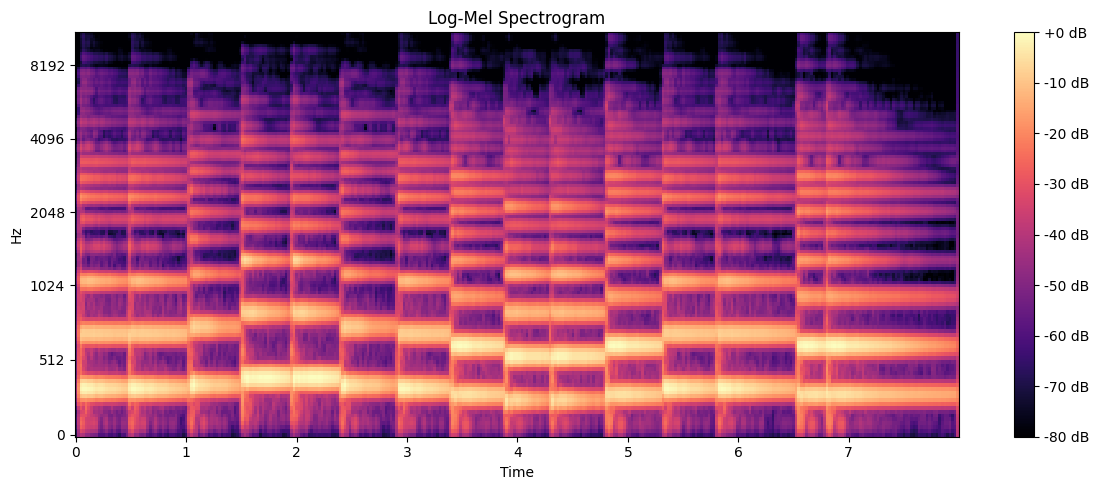

In [6]:
# visualize the first 8 seconds of the log-mel spectrogram for a good Ode to Joy practice
mp3_path = 'practiceode.mp3'
log_mel_spectrogram = log_mel(mp3_path)
normalized_spectrogram = normalize_spectogram(log_mel_spectrogram)

ipd.display(ipd.Audio(mp3_path))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    log_mel_spectrogram,
    sr=22050,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()

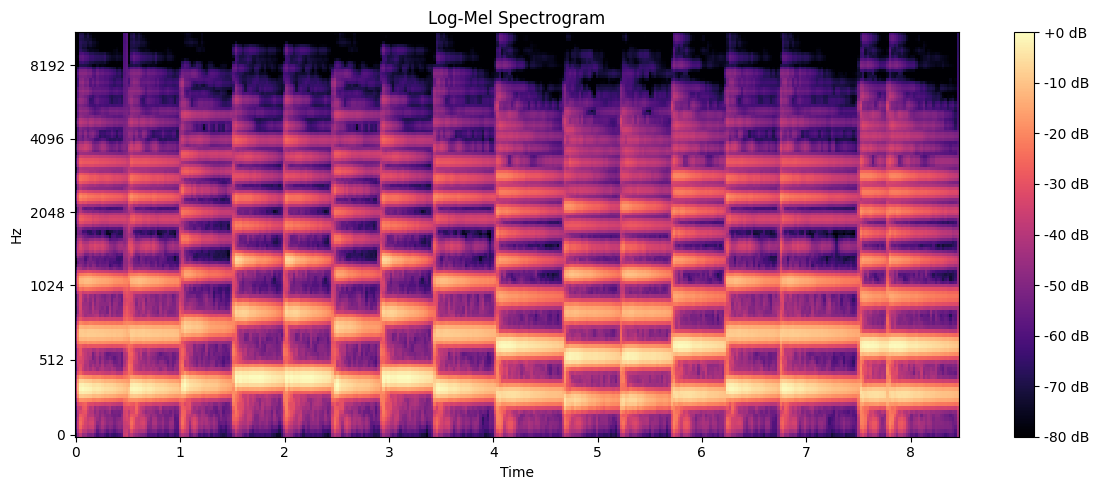

In [7]:
# visualize the first 8 seconds of the log-mel spectrogram for a not so good Ode to Joy practice
mp3_path = 'badode.mp3'
log_mel_spectrogram = log_mel(mp3_path)
normalized_spectrogram = normalize_spectogram(log_mel_spectrogram)

ipd.display(ipd.Audio(mp3_path))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    log_mel_spectrogram,
    sr=22050,
    hop_length=512,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()

In [8]:
def gaussian_pyramid(spectogram, levels=4, sigma=1, downscale=2, minsize=16):
    pyramid = [spectogram]
    current_level = spectogram
    for _ in range(1, levels):
        # Apply Gaussian filter
        blurred = gaussian_filter(current_level, sigma=sigma)
        # Downsample the spectrogram
        downsampled = blurred[::downscale, ::downscale]
        if downsampled.shape[0] < minsize or downsampled.shape[1] < minsize:
            break
        pyramid.append(downsampled)
        current_level = downsampled
    return pyramid

In [9]:
S_ideal = log_mel('practiceode.mp3')
S_prac  = log_mel('badode.mp3')
ideal_pyr = gaussian_pyramid(S_ideal, levels=4, sigma=1.0, downscale=2)
prac_pyr  = gaussian_pyramid(S_prac,  levels=4, sigma=1.0, downscale=2)

Utility Functions for Step-wise Dynamic Time Warp

In [10]:
def upscale_path(path, scale_i, scale_j, max_i, max_j):
    # Map coarse-level indices to fine-level indices.
    up = [(
        min(max_i - 1, int(round(i * scale_i))),
        min(max_j - 1, int(round(j * scale_j)))
    ) for i, j in path]
    up_sorted = []
    last = (-1, -1)
    for p in up:
        if p != last:
            up_sorted.append(p)
            last = p
    return up_sorted


def create_centerline(path, len_i):
    # Build a centerline array of length len_i. Fill unknowns by forward/backward filling
    center = np.full(len_i, -1, dtype=np.int32)
    for i, j in path:
        if 0 <= i < len_i:
            center[i] = j

    # If there are no valid points, return a default centerline (zeros)
    valid_idx = np.where(center != -1)[0]
    if len(valid_idx) == 0:
        return np.zeros(len_i, dtype=np.int32)

    # Fill leading -1s with the first valid value
    first = valid_idx[0]
    if first > 0:
        center[:first] = center[first]

    # Forward-fill the rest
    for idx in range(first + 1, len_i):
        if center[idx] == -1:
            center[idx] = center[idx - 1]
    return center


def create_corridor(centerline, width, len_j):
    corridor = np.zeros((len(centerline), len_j), dtype=bool)
    for i, center_j in enumerate(centerline):
        if center_j != -1:
            start = max(0, center_j - width)
            end = min(len_j, center_j + width + 1)
            corridor[i, start:end] = True
    return corridor


def cosine_dist_frames(S_prac, S_ideal, i, j, eps=1e-8):
    a = S_prac[:, i]
    b = S_ideal[:, j]
    return 1.0 - (np.dot(a, b) / ((np.linalg.norm(a) * np.linalg.norm(b)) + eps))


def diagonal_corridor(TP, TI, ratio, width):
    centerline = np.zeros(TP, dtype=np.int32)
    for i in range(TP):
        centerline[i] = int(i / ratio)
    centerline = np.clip(centerline, 0, TI - 1)
    return create_corridor(centerline, width, TI)


In [11]:
def dtw(S_prac, S_ideal, corridor):
    TP = S_prac.shape[1]
    TI = S_ideal.shape[1]
    INF = 1e18

    D = np.full((TP, TI), INF, dtype=np.float64)
    back = np.full((TP, TI, 2), -1, dtype=np.int32)

    if corridor[0, 0]: # initialization/start point
        D[0, 0] = cosine_dist_frames(S_prac, S_ideal, 0, 0)
        back[0, 0] = (-1, -1)

    for i in range(TP):
        js = np.where(corridor[i])[0]
        for j in js:
            if i == 0 and j==0:
                continue
            cost = cosine_dist_frames(S_prac, S_ideal, i, j)
            best_val = INF
            best_prev = (-1, -1)

            # from (i-1, j)  (up)
            if i - 1 >= 0 and corridor[i - 1, j] and D[i - 1, j] < best_val:
                best_val = D[i - 1, j]
                best_prev = (i - 1, j)

            # from (i, j-1)  (left)
            if j - 1 >= 0 and corridor[i, j - 1] and D[i, j - 1] < best_val:
                best_val = D[i, j - 1]
                best_prev = (i, j - 1)

            # from (i-1, j-1) (diag)
            if i - 1 >= 0 and j - 1 >= 0 and corridor[i - 1, j - 1] and D[i - 1, j - 1] < best_val:
                best_val = D[i - 1, j - 1]
                best_prev = (i - 1, j - 1)

            if best_prev != (-1, -1):
                D[i, j] = best_val + cost
                back[i, j] = best_prev

    end_i, end_j = TP - 1, TI - 1
    if not (corridor[end_i, end_j] and np.isfinite(D[end_i, end_j])):
        last_row_js = np.where(corridor[end_i])[0]
        if len(last_row_js) == 0:
            raise ValueError("No valid corridor cells in last row; corridor too tight.")
        end_j = last_row_js[np.argmin(D[end_i, last_row_js])]

    path = []
    i, j = end_i, end_j
    if not np.isfinite(D[i, j]):
        raise ValueError("DTW failed: end cell unreachable. Widen corridor.")
    while i >= 0 and j >= 0:
        path.append((i, j))
        pi, pj = back[i, j]
        if pi < 0:
            break
        i, j = int(pi), int(pj)

    path.reverse()
    return path, float(D[i, j])

In [12]:
def course_dtw_with_tempo_trials(S_prac, S_ideal, tempo_bounds=(0.8,1.2), trials=TRIALS, width=12):
    TP, TI = S_prac.shape[1], S_ideal.shape[1]
    ratios = np.linspace(tempo_bounds[0], tempo_bounds[1], trials)
    best_path, best_cost, best_ratio = None, float('inf'), None

    for r in ratios:
        corridor = diagonal_corridor(TP, TI, ratio=r, width=width)
        path, cost = dtw(S_prac, S_ideal, corridor)
        if cost < best_cost:
            best_path, best_cost, best_ratio = path, cost, r

    return best_path, best_cost, best_ratio

In [13]:
def pyramid_dtw(ideal_pyr, prac_pyr, tempo_bounds=(0.8,1.2), trials=TRIALS, coarse_width=COARSE_WIDTH, refine_width=REFINE_WIDTH):
    L = min(len(ideal_pyr), len(prac_pyr))
    log = []
    lvl = L - 1
    S_ideal = ideal_pyr[lvl]
    S_prac  = prac_pyr[lvl]

    path, cost, best_ratio = course_dtw_with_tempo_trials(
        S_prac, S_ideal, tempo_bounds=tempo_bounds, trials=trials, width=coarse_width
    )
    log.append({"level": lvl, "cost": cost, "best_ratio": best_ratio, "shape_prac": S_prac.shape, "shape_ideal": S_ideal.shape})

    for lvl in range(L - 2, -1, -1):
        S_ideal = ideal_pyr[lvl]
        S_prac  = prac_pyr[lvl]

        # Use the practice pyramid's next coarser level to compute the practice-scale
        # (map indices from the coarser prac level up to the current prac level).
        scale_i = S_prac.shape[1] / prac_pyr[lvl + 1].shape[1]
        scale_j = S_ideal.shape[1] / ideal_pyr[lvl + 1].shape[1]
        up_path = upscale_path(path, scale_i, scale_j, S_prac.shape[1], S_ideal.shape[1])
        centerline = create_centerline(up_path, S_prac.shape[1])
        corridor = create_corridor(centerline, refine_width, S_ideal.shape[1])

        path, cost = dtw(S_prac, S_ideal, corridor)
        log.append({"level": lvl, "cost": cost, "shape_prac": S_prac.shape, "shape_ideal": S_ideal.shape, "corridor": corridor})
    return path, log


In [14]:
final_path, per_level_log = pyramid_dtw(
    ideal_pyr, prac_pyr,
    tempo_bounds=(0.8, 1.2),
    trials=TRIALS,
    coarse_width=COARSE_WIDTH,
    refine_width=REFINE_WIDTH
)

print("Final path length:", len(final_path))
print("Per-level log:")
for row in per_level_log:
    print(row)

Final path length: 395
Per-level log:
{'level': 3, 'cost': 0.0001944899559020996, 'best_ratio': np.float64(0.8), 'shape_prac': (16, 46), 'shape_ideal': (16, 44)}
{'level': 2, 'cost': 0.0007273554801940918, 'shape_prac': (32, 92), 'shape_ideal': (32, 87), 'corridor': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(92, 87))}
{'level': 1, 'cost': 0.0017278194427490234, 'shape_prac': (64, 183), 'shape_ideal': (64, 173), 'corridor': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, Fa

In [15]:
def ideal_corridor_lines(TP, TI, tempo_bounds):
    r_min, r_max = tempo_bounds

    i_vals = np.arange(TP)

    # j = i / ratio
    j_upper = i_vals / r_min   # slower practice
    j_lower = i_vals / r_max   # faster practice

    # clip to valid j range
    j_upper = np.clip(j_upper, 0, TI - 1)
    j_lower = np.clip(j_lower, 0, TI - 1)

    return i_vals, j_lower, j_upper

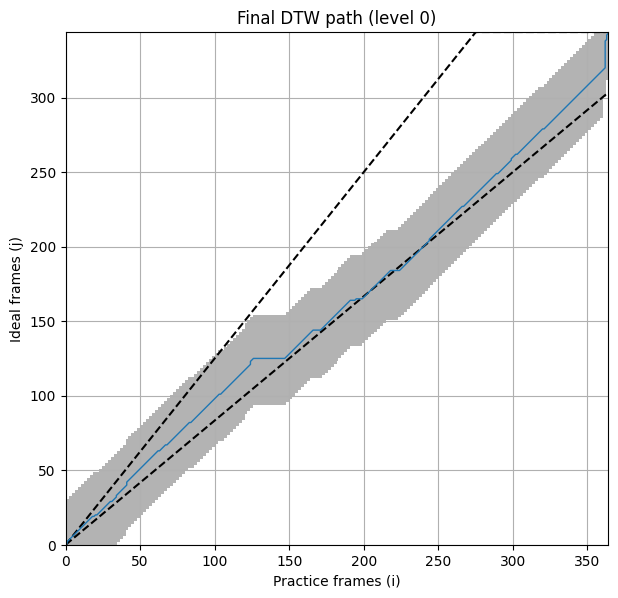

In [16]:
def plot_path(path, corridor, title="Warping path"):

    TP, TI = corridor.shape

    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    plt.figure(figsize=(7,7))

    plt.imshow(
        corridor.T,
        origin='lower',
        cmap='Greys',
        interpolation='nearest',
        extent=[0, TP-1, 0, TI-1],
        alpha=0.3
    )

    i_vals, j_lo, j_hi = ideal_corridor_lines(TP, TI, TEMPO_BOUNDS)
    plt.plot(i_vals, j_lo, "k--", linewidth=1.5, label="ideal tempo bounds")
    plt.plot(i_vals, j_hi, "k--", linewidth=1.5)


    plt.plot(xs, ys, linewidth=1)
    plt.xlabel("Practice frames (i)")
    plt.ylabel("Ideal frames (j)")
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, TP-1)
    plt.ylim(0, TI-1)
    plt.show()

corridor0 = per_level_log[-1]['corridor']
plot_path(final_path, corridor0, "Final DTW path (level 0)")

# Approach 2: Constant-Q Transform + DTW

Instead of computing log-mel spectrograms for the practice piano recordings, we use the Constant-Q Transform (CQT) as our primary time–frequency representation.

The key motivation for this change is that CQT bins are logarithmically spaced and align closely with musical pitch. When configured with 12 bins per octave, each frequency bin approximately corresponds to a single semitone, making CQT far more suitable for pitch-related analysis than mel spectrograms. This is especially important for piano, where small pitch differences (e.g., one wrong note) are musically significant but can be blurred in mel-scaled representations.

For instance, the logarithmic spacing of notes in CQT puts A4, A#, and B4 in different frequency bins, while log mel does not make as much of a distinction here.

In [17]:
def cqt(audio_path, sr=22050, hop_length=512, fmin=27.5, n_bins=84, bins_per_octave=12):
    y, _ = librosa.load(audio_path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)

    C = librosa.cqt(y, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    C_mag = np.abs(C)
    C_db = librosa.amplitude_to_db(C_mag, ref=np.max)
    C_norm = (C_db - C_db.min()) / (C_db.max() - C_db.min() + 1e-8)

    return C_norm

The following utility functions are used for the pitch scoring of a practice recording.

In [18]:
def cosine_similarity(a, b, eps=1e-8):
    return float(np.dot(a, b) / ((np.linalg.norm(a) * np.linalg.norm(b)) + eps))

def keep_topk_bins(col, K=15):
    out = np.zeros_like(col)
    idx = np.argpartition(col, -K)[-K:]
    out[idx] = col[idx]
    return out

## Pitch Accuracy Scoring

The frame_pitch_score() method essentially finds the pitch energy score within one aligned frame. It essentially finds the top-K expected pitch bins from the ideal frame and numerates the amount of energy matches that the practice pitch has with the ideal. I also took account of the harmonics.

In short, for each aligned frame, we see how much of the energy matches that of the ideal bins, and compute a score between 0 and 1. Take the average of scores across frames.

In [19]:
def frame_pitch_score(ideal_col, prac_col, K=3, window=1, eps=1e-8):
    if ideal_col.max() < 0.05:
        return np.nan  # No pitch in ideal frame
    expected = np.argsort(ideal_col)[-K:]  # Indices of top K pitches in ideal frame
    mask = np.zeros_like(prac_col, dtype=bool)

    harmonic_offsets = [0, 12, 19, 24]  # Unison, Octave, Perfect Fifth, Two Octaves
    for idx in expected:
        for offset in harmonic_offsets:
            idx_offset = idx + offset
            if 0 <= idx_offset < prac_col.shape[0]:
                lo = max(0, idx_offset - window)
                hi = min(prac_col.shape[0], idx_offset + window + 1)
                mask[lo:hi] = True

    
    total_energy = np.sum(prac_col) + eps
    return float(np.sum(prac_col[mask]) / total_energy)

In [20]:
def pitch_accuracy_from_path(C_prac, C_ideal, path, silence_thr=0.05, K=15): # essentially combines frame_pitch_score over all aligned frames
    scores = []
    for i, j in path:
        a = C_ideal[:, j]
        b = C_prac[:, i]
        if a.max() < silence_thr:
            continue
        a2 = keep_topk_bins(a, K)
        b2 = keep_topk_bins(b, K)
        scores.append(cosine_similarity(a2, b2))
    scores = np.array(scores) if scores else np.array([])
    return float(scores.mean() * 100.0) if scores.size else 0.0, scores

In [21]:
def gaussian_pyramid_time_only(S, levels=4, sigma=(0.0, 1.0), downscale_t=2, minT=16):
    pyramid = [S]
    cur = S
    for _ in range(1, levels):
        blurred = gaussian_filter(cur, sigma=sigma)  # blur mostly in time
        down = blurred[:, ::downscale_t]             # downsample time only
        if down.shape[1] < minT:
            break
        pyramid.append(down)
        cur = down
    return pyramid

In [22]:
def plot_path_with_frame_scores(path, corridor, fs, title="Warping path"):

    TP, TI = corridor.shape

    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    plt.figure(figsize=(7,7))

    plt.imshow(
        corridor.T,
        origin='lower',
        cmap='Greys',
        interpolation='nearest',
        extent=[0, TP-1, 0, TI-1],
        alpha=0.3
    )

    i_vals, j_lo, j_hi = ideal_corridor_lines(TP, TI, TEMPO_BOUNDS)
    plt.plot(i_vals, j_lo, "k--", linewidth=1.5, label="ideal tempo bounds")
    plt.plot(i_vals, j_hi, "k--", linewidth=1.5)


    plt.plot(xs, ys, linewidth=1)
    plt.scatter(xs, ys, c=fs, cmap="viridis", s=10)
    plt.colorbar(label="Pitch correctness")
    plt.xlabel("Practice frames (i)")
    plt.ylabel("Ideal frames (j)")
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, TP-1)
    plt.ylim(0, TI-1)
    plt.show()

Final path length: 395
Per-level log:
{'level': 3, 'cost': 0.00557255744934082, 'best_ratio': np.float64(0.8), 'shape_prac': (84, 46), 'shape_ideal': (84, 44)}
{'level': 2, 'cost': 0.009161889553070068, 'shape_prac': (84, 92), 'shape_ideal': (84, 87), 'corridor': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(92, 87))}
{'level': 1, 'cost': 0.016677916049957275, 'shape_prac': (84, 183), 'shape_ideal': (84, 173), 'corridor': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False,

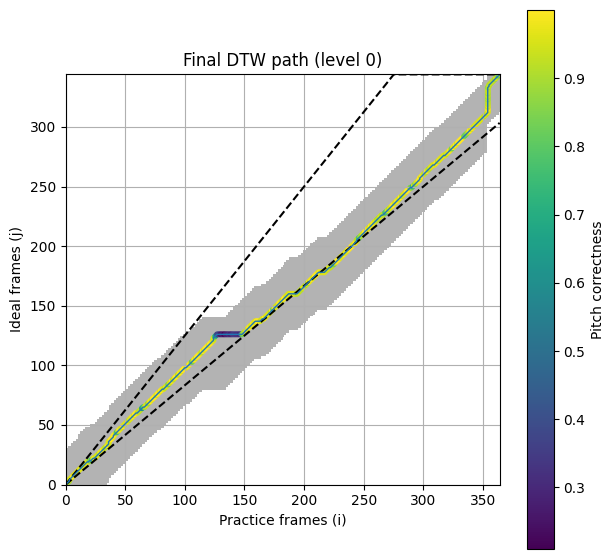

In [32]:
# let's put it all together!
mp3_ideal = 'practiceode.mp3'
mp3_prac  = 'badode.mp3'
C_ideal = cqt(mp3_ideal)
C_prac  = cqt(mp3_prac)

ideal_pyr = gaussian_pyramid_time_only(C_ideal, levels=4, sigma=1, downscale_t=2)
prac_pyr  = gaussian_pyramid_time_only(C_prac,  levels=4, sigma=1, downscale_t=2)

final_path, per_level_log = pyramid_dtw(ideal_pyr, prac_pyr,
    tempo_bounds=(0.8, 1.2),
    trials=TRIALS,
    coarse_width=COARSE_WIDTH,
    refine_width=REFINE_WIDTH
)

print("Final path length:", len(final_path))
print("Per-level log:")
for row in per_level_log:
    print(row)

accuracy, frame_scores = pitch_accuracy_from_path(C_prac, C_ideal, final_path)
print(f"Pitch accuracy: {accuracy:.2f}%")
corridor0 = per_level_log[-1]['corridor']
plot_path_with_frame_scores(final_path, corridor0, frame_scores, "Final DTW path (level 0)")


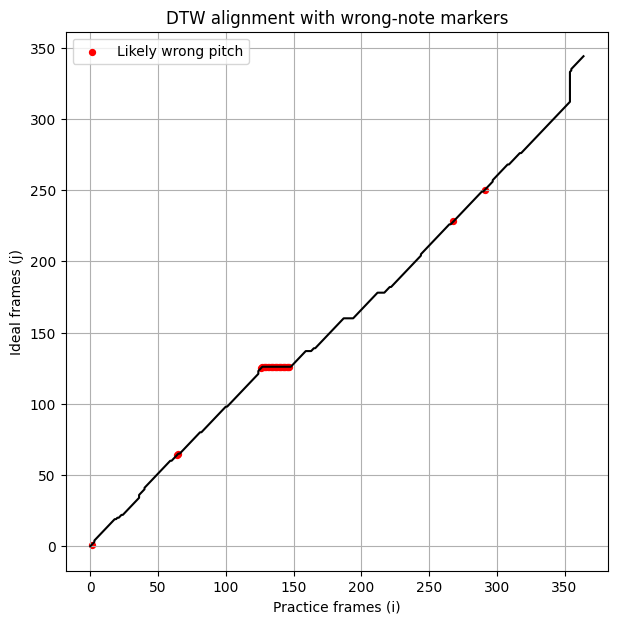

In [33]:
bad = frame_scores < 0.75   # tune threshold

plt.figure(figsize=(7,7))

# DTW path
xs = [p[0] for p in final_path]
ys = [p[1] for p in final_path]
plt.plot(xs, ys, color="black", linewidth=1.5)

plt.scatter(
    np.array(xs)[bad],
    np.array(ys)[bad],
    color="red",
    s=18,
    label="Likely wrong pitch"
)

plt.legend()
plt.xlabel("Practice frames (i)")
plt.ylabel("Ideal frames (j)")
plt.title("DTW alignment with wrong-note markers")
plt.grid(True)
plt.show()

## Tempo Accuracy Scoring

In [40]:
def tempo_score(path, smooth=15, eps=1e-8):
    i_idx = []
    slope = []
    for k in range(1, len(path)):
        i0, j0 = path[k - 1]
        i1, j1 = path[k]
        di = i1 - i0
        dj = j1 - j0
        if di > 0:
            i_idx.append(i1)
            slope.append(dj / (di + eps))
    if len(slope) == 0:
        return 0.0, np.array([]), np.array([])
    slope = np.array(slope)
    i_idx = np.array(i_idx)

    if smooth and smooth > 1:
        kernel = np.ones(smooth) / smooth
        slope_s = np.convolve(slope, kernel, mode='same')
    else:
        slope_s = slope
    
    dev = np.abs(np.log(slope_s + eps))
    tolerance = np.log(1.10)
    per_frame = np.clip(1.0 - (dev / tolerance), 0.0, 1.0)

    tempo_accuracy = per_frame.mean() * 100.0
    return tempo_accuracy, i_idx, slope

Tempo accuracy: 43.16%


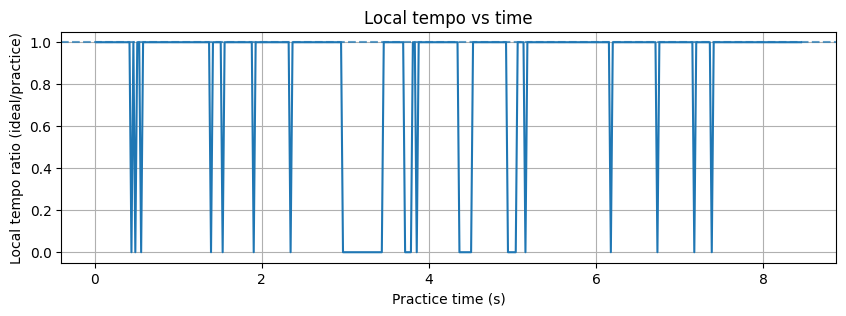

In [38]:
tempo_score, i_idx, slope = tempo_score(final_path, smooth=15)
print(f"Tempo accuracy: {tempo_score:.2f}%")

sr = 22050
t = i_idx * HOP_LENGTH / sr

plt.figure(figsize=(10,3))
plt.plot(t, slope)
plt.axhline(1.0, linestyle="--", alpha=0.7)
plt.xlabel("Practice time (s)")
plt.ylabel("Local tempo ratio (ideal/practice)")
plt.title("Local tempo vs time")
plt.grid(True)
plt.show()

# Unit Testing

### Test 1: 5 note staircase:
Ideal: A C E C A

Practice: A C E D A

We need to see if our cwt and dtw algorithm can detect the fault in our 4th note!

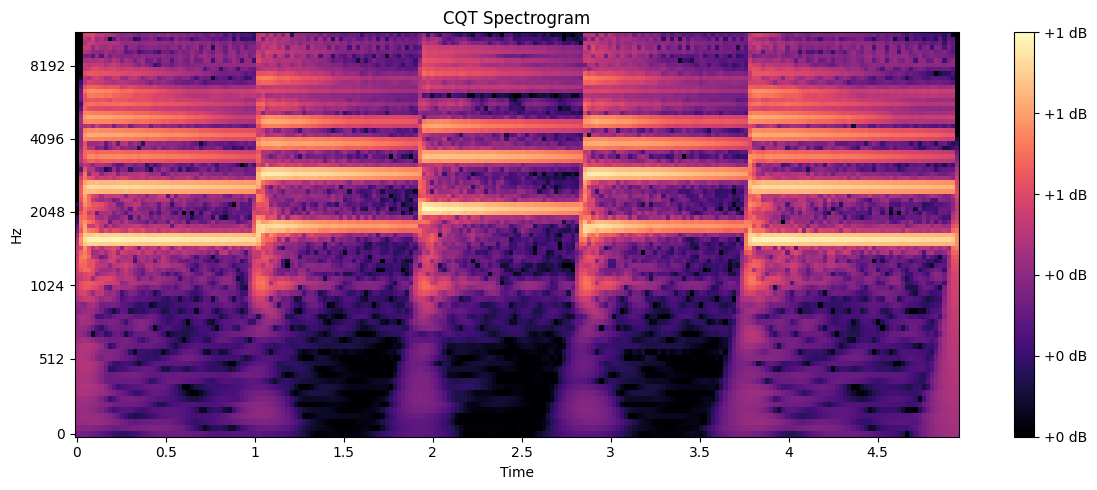

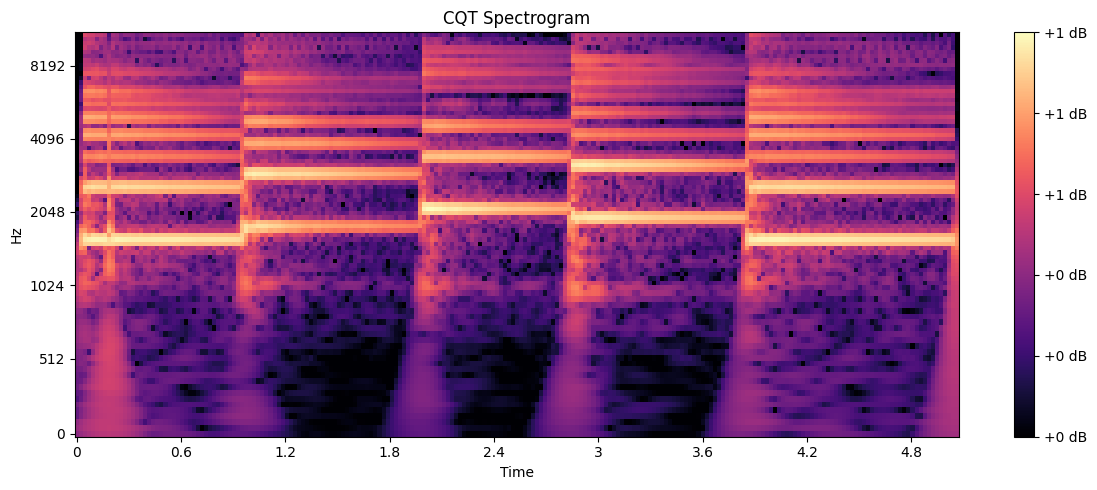

5-note practice pitch accuracy: 84.15%
5-note practice tempo accuracy: 86.24%


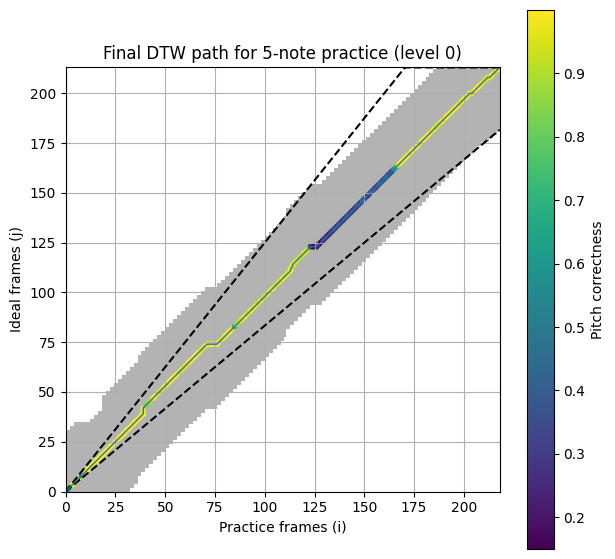

In [41]:
ideal_0_mp3 = '5_note_ideal.mp3'
prac_0_mp3  = '5_note_prac.mp3'
C_ideal_0 = cqt(ideal_0_mp3)
C_prac_0  = cqt(prac_0_mp3)

ipd.display(ipd.Audio(ideal_0_mp3))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    C_ideal_0,
    sr=22050,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("CQT Spectrogram")
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(prac_0_mp3))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    C_prac_0,
    sr=22050,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("CQT Spectrogram")
plt.tight_layout()
plt.show()

final_path_0, per_level_log_0 = pyramid_dtw(
    gaussian_pyramid_time_only(C_ideal_0, levels=4, sigma=1, downscale_t=2),
    gaussian_pyramid_time_only(C_prac_0,  levels=4, sigma=1, downscale_t=2),
    tempo_bounds=(0.8, 1.2),
    trials=TRIALS,
    coarse_width=COARSE_WIDTH,
    refine_width=REFINE_WIDTH
)
accuracy_0, frame_scores_0 = pitch_accuracy_from_path(C_prac_0, C_ideal_0, final_path_0)
print(f"5-note practice pitch accuracy: {accuracy_0:.2f}%")
tempo_score_0, i_idx_0, slope_0 = tempo_score(final_path_0, smooth=5)
print(f"5-note practice tempo accuracy: {tempo_score_0:.2f}%")
corridor0_0 = per_level_log_0[-1]['corridor']
plot_path_with_frame_scores(final_path_0, corridor0_0, frame_scores_0, "Final DTW path for 5-note practice (level 0)")


### Test 2: Tempo differences

Ideal is faster: A C E C A

Practice is slower: A C E C A

Ideally, pitches accuracy should be pretty high, but tempo should be low and out of the corridor bounds.

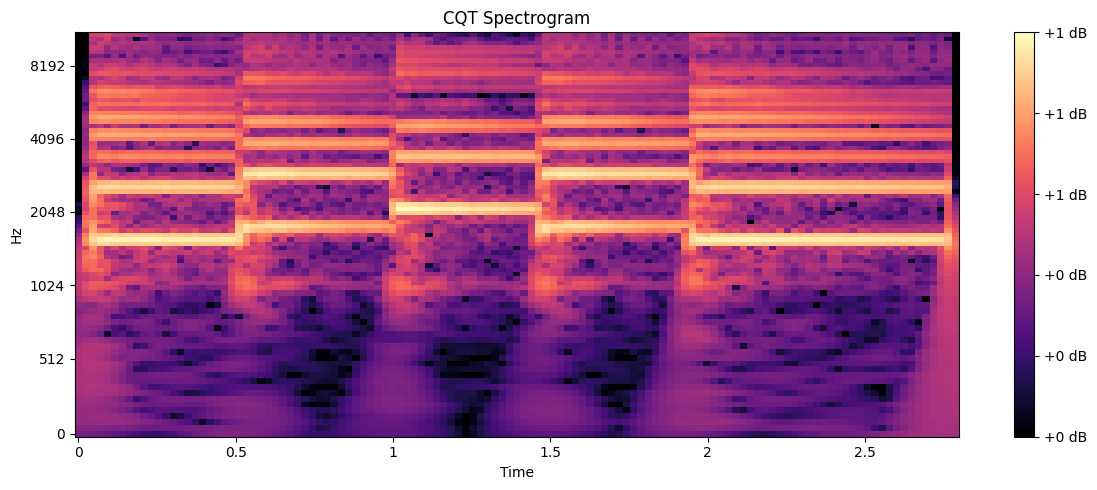

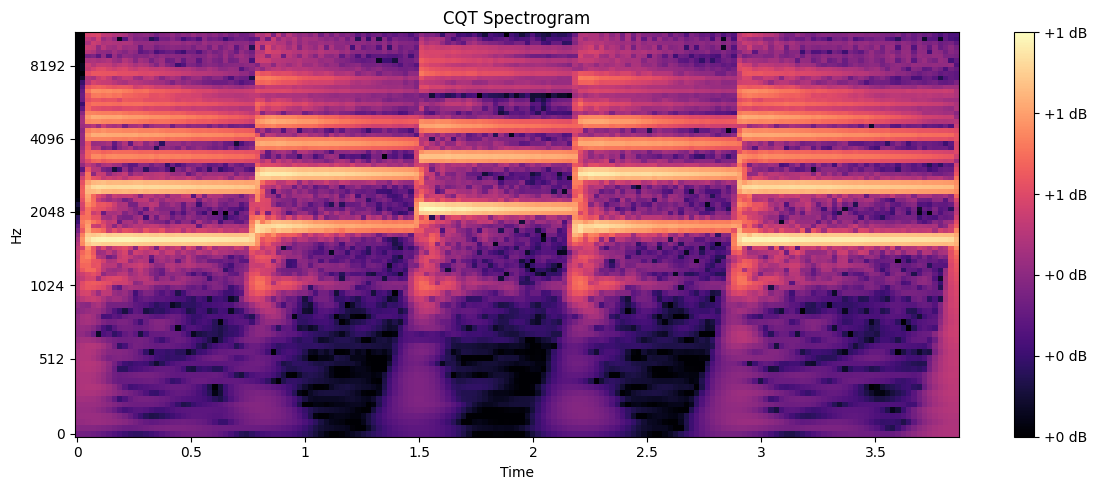

5-note practice pitch accuracy: 96.61%
5-note practice tempo accuracy: 50.00%


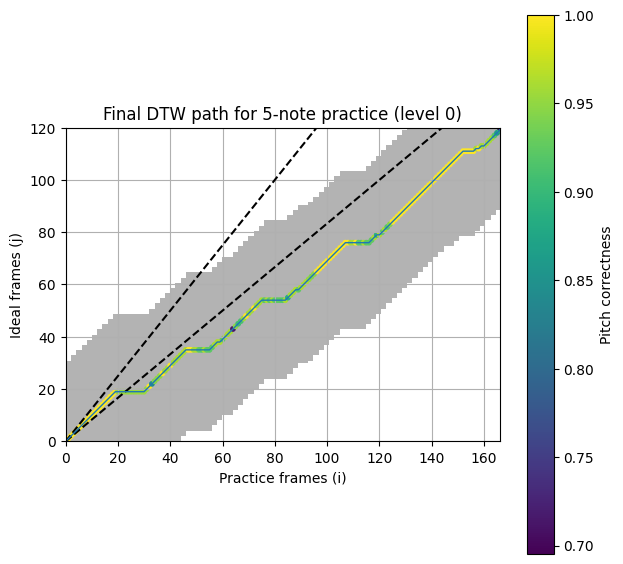

In [43]:
ideal_1_mp3 = 'fast_ideal.mp3'
prac_1_mp3  = 'slow_practice.mp3'
C_ideal_1 = cqt(ideal_1_mp3)
C_prac_1  = cqt(prac_1_mp3)

ipd.display(ipd.Audio(ideal_1_mp3))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    C_ideal_1,
    sr=22050,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("CQT Spectrogram")
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(prac_1_mp3))

plt.figure(figsize=(12, 5))
librosa.display.specshow(
    C_prac_1,
    sr=22050,
    hop_length=HOP_LENGTH,
    x_axis="time",
    y_axis="mel",
)

plt.colorbar(format="%+2.0f dB")
plt.title("CQT Spectrogram")
plt.tight_layout()
plt.show()

final_path_1, per_level_log_1 = pyramid_dtw(
    gaussian_pyramid_time_only(C_ideal_1, levels=4, sigma=1, downscale_t=2),
    gaussian_pyramid_time_only(C_prac_1,  levels=4, sigma=1, downscale_t=2),
    tempo_bounds=(0.8, 1.2),
    trials=TRIALS,
    coarse_width=COARSE_WIDTH,
    refine_width=REFINE_WIDTH
)
accuracy_1, frame_scores_1 = pitch_accuracy_from_path(C_prac_1, C_ideal_1, final_path_1)
print(f"5-note practice pitch accuracy: {accuracy_1:.2f}%")
tempo_score_1, i_idx_1, slope_1 = tempo_score(final_path_1, smooth=5)
print(f"5-note practice tempo accuracy: {tempo_score_1:.2f}%")
corridor1_1 = per_level_log_1[-1]['corridor']
plot_path_with_frame_scores(final_path_1, corridor1_1, frame_scores_1, "Final DTW path for 5-note practice (level 0)")


Pitch Score Calculation

In [19]:
def pitch_mismatch_rate(S_prac, S_ideal, path, bin_threshold=3):
    mismatches = 0
    total = 0
    for (i, j) in path:
        A = int(np.argmax(S_prac[:, i]))
        B = int(np.argmax(S_ideal[:, j]))
        if abs(A - B) > bin_threshold:
            mismatches += 1
        total += 1
    pmr = mismatches / total if total > 0 else 0.0
    return float(pmr)

def pitch_accuracy_score(pitch_mismatch_rate):
    return float(100.0 * (1.0 - pitch_mismatch_rate))